In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# Datos

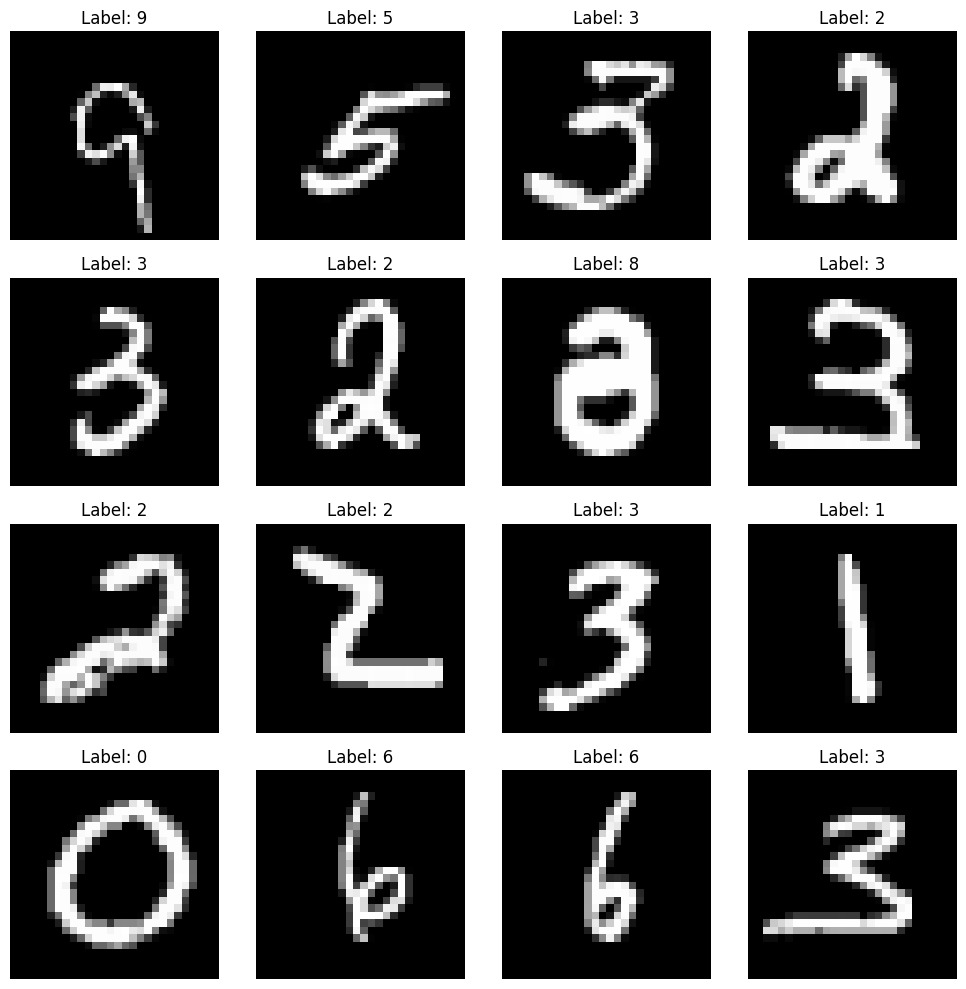

In [3]:

# Load MNIST dataset
# Definimos una secuencia de transformaciones para aplicar a las imágenes del dataset.
# En este caso, solo convertimos las imágenes a tensores utilizando `ToTensor()`.
# Esto es necesario para que las imágenes estén en un formato compatible con PyTorch.
transform = transforms.Compose([
    transforms.ToTensor()  # Convierte la imagen de un formato PIL o numpy.ndarray a un tensor.
])

# Cargamos el dataset MNIST de entrenamiento.
# `root='./data'` especifica el directorio donde se descargarán los datos si no están presentes.
# `train=True` indica que queremos el conjunto de datos de entrenamiento.
# `transform=transform` aplica las transformaciones definidas previamente a cada imagen.
# `download=True` descarga los datos si no están disponibles en el directorio especificado.
mnist_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)

# Creamos un DataLoader que nos permite cargar los datos en lotes pequeños.
# `dataset=mnist_dataset` es el dataset que se cargará.
# `batch_size=16` indica que cada lote contendrá 16 imágenes y etiquetas.
# `shuffle=True` mezcla los datos aleatoriamente en cada época, mejorando la generalización del modelo.
data_loader = DataLoader(
    mnist_dataset, batch_size=16, shuffle=True
)

# Obtenemos un único lote de datos del DataLoader.
# `next(iter(data_loader))` convierte el DataLoader en un iterador y toma el primer lote.
# El lote contiene `images` (los tensores de las imágenes) y `labels` (las etiquetas correspondientes).
images, labels = next(iter(data_loader))


# Plot the images in a grid
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Arquitectura

In [6]:

# Definimos el modelo MLP
# MLP hereda de nn.Module, lo que permite utilizar las funciones y propiedades de PyTorch
# para crear, entrenar y evaluar redes neuronales.
class MLP(nn.Module):
    def __init__(self):
        # Inicializamos la clase base nn.Module
        # Esto habilita funciones esenciales como la gestión de capas y forward pass.
        super(MLP, self).__init__()
        
        # Capa completamente conectada: de entrada (28x28 píxeles) a 512 neuronas
        self.fc1 = nn.Linear(28 * 28, 256)
        # Capa oculta: de 512 neuronas a 256 neuronas
        self.fc2 = nn.Linear(256, 128)
        # Capa de salida: de 256 neuronas a 10 clases (números del 0 al 9)
        self.fc3 = nn.Linear(128, 10)

        # Función de activación ReLU
        self.relu = nn.ReLU()

        # Función de activación ReLU
        self.LeakyReLU = nn.LeakyReLU()

        # # Función de activación Tanh
        # self.tanh = nn.tanh()

        # Dropout para evitar sobreajuste, porcentaje de neuronas apagadas.
        self.dropout = nn.Dropout(0.2)

    # Definimos cómo pasa la información a través de la red
    # Este método es obligatorio en las clases que heredan de nn.Module.
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplanamos las imágenes (de 28x28 a 1D)
        x = self.LeakyReLU(self.fc1(x))  # Aplicamos la primera capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.LeakyReLU(self.fc2(x))  # Aplicamos la segunda capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.fc3(x)             # Aplicamos la capa de salida
        return x
    
    # Si se usase una función sigmoide, tendría que ser aplicada al final después de self.fc3

# Entrenamiento

In [7]:
# Hiperparámetros
batch_size = 64       # Tamaño de lote
learning_rate = 0.001 # Tasa de aprendizaje
epochs = 10           # Número de épocas de entrenamiento

# Preprocesamiento y carga de datos de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),                 # Convertimos imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizamos a media 0 y varianza 1
])
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)  # Dataset de entrenamiento
test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)  # Dataset de prueba
train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)  # Dataloader para entrenamiento
test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)  # Dataloader para prueba

# Definimos el modelo, la función de pérdida y el optimizador
model = MLP()                             # Creamos una instancia del modelo MLP
criterion = nn.CrossEntropyLoss()         # Función de pérdida para clasificación
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizador Adam

# Bucle de entrenamiento
for epoch in range(epochs):
    model.train()  # Ponemos el modelo en modo entrenamiento
    for images, labels in train_loader:  # Iteramos sobre lotes de datos
        optimizer.zero_grad()            # Reiniciamos los gradientes
        outputs = model(images)          # Hacemos una predicción con el modelo
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()                  # Propagamos los gradientes
        optimizer.step()                 # Actualizamos los pesos del modelo

    # Mostramos la pérdida al final de cada época
    print(f"Época [{epoch+1}/{epochs}], Pérdida: {loss.item():.4f}")



Época [1/10], Pérdida: 0.5440
Época [2/10], Pérdida: 0.3085
Época [3/10], Pérdida: 0.2345
Época [4/10], Pérdida: 0.0321
Época [5/10], Pérdida: 0.2705
Época [6/10], Pérdida: 0.0196
Época [7/10], Pérdida: 0.0883
Época [8/10], Pérdida: 0.1272
Época [9/10], Pérdida: 0.0601
Época [10/10], Pérdida: 0.2973


# Evaluación del modelo

In [8]:
model.eval()  # Ponemos el modelo en modo evaluación (desactiva Dropout)
correct = 0
total = 0
with torch.no_grad():  # Desactivamos el cálculo de gradientes para evaluación
    for images, labels in test_loader:  # Iteramos sobre los datos de prueba
        outputs = model(images)         # Hacemos predicciones
        _, predicted = torch.max(outputs.data, 1)  # Obtenemos la clase con mayor probabilidad
        total += labels.size(0)         # Total de muestras evaluadas
        correct += (predicted == labels).sum().item()  # Contamos las predicciones correctas

# Calculamos y mostramos la precisión del modelo
accuracy = 100 * correct / total
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}%")

Accuracy en el conjunto de prueba: 97.67%


PERCEPTRON MULTICAPA


## Descripción de Pruebas Realizadas
**Claudio Bastias - Ignacio Carrere**

1. Prueba Número 1: probamos aumentar las neuronas en la capa dos, manteniendo la congruencia.        
        # Capa completamente conectada: de entrada (28x28 píxeles) a 512 neuronas
        self.fc1 = nn.Linear(28 * 28, 150)
        # Capa oculta: de 512 neuronas a 256 neuronas
        # self.fc2 = nn.Linear(150, 300)
        # Capa de salida: de 256 neuronas a 10 clases (números del 0 al 9)
        # self.fc3 = nn.Linear(300, 10)

Tuvo precisión de 97,5%

2. Prueba número 2: probamos cambiar la capa uno por 256 neuronas, la segunda por 128 a recomendación de ayudante.
Modelo tuvo precisión de 97.06%

3. Prueba número 3: cambiamos función de activación de ReLU por LeakyReLU.
Accuracy en el conjunto de prueba: 97.74%

Por que mejoro el accuracy en este caso?

a.- mayor información aprovechada, al usar LeakyRelu, se pudieron activar más neuronas en capas profundas, permitiendo que la red capatara mayor
cantidad de patrones relevantesd de los datos en el Modelo.

b. Al mejorar la propagacion del gradiente, el modelo pudo ajustar mejor los pesos, lo que se traduce en un mejor desempeño en el conujunto de las pruebas

c. Por último el salto en el accuracy del 97.74% indica que la red neuronal aprovechó mejor la información gracias a este pequeño cambio en la funcion de activación

In [10]:
# Verificar si hay una GPU disponible, de lo contrario usar la CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocesamiento: Definir transformaciones para los datos
transform = transforms.Compose([
    transforms.ToTensor(),                # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizar los valores a un rango de [-1, 1]
])

# Cargar el conjunto de datos MNIST
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)  # Datos de entrenamiento
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)  # Datos de prueba

# Crear DataLoaders para manejar los datos de forma eficiente
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)   # Loader para entrenamiento (batch de 128, mezclado)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)    # Loader para prueba (batch de 128, sin mezclar)

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)   # Loader para entrenamiento (batch de 32, mezclado)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)    # Loader para prueba (batch de 32, sin mezclar)

class CNN(nn.Module):
    def __init__(self, verbose=False, filters_l1=64, filters_l2=128, dropout=0.3, final_layer_size=256):
        #def __init__(self, verbose=False, filters_l1=32, filters_l2=64, dropout=0.2, final_layer_size=128):
        super(CNN, self).__init__()
        self.verbose = verbose
        self.filters_l1 = filters_l1
        self.filters_l2 = filters_l2
        self.dropout_rate = dropout
        self.final_layer_size = final_layer_size

        # Primera capa convolucional
        self.conv1 = nn.Conv2d(1, self.filters_l1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Segunda capa convolucional
        self.conv2 = nn.Conv2d(self.filters_l1, self.filters_l2, kernel_size=3, stride=1, padding=1)

        # Calcular automáticamente las dimensiones de la capa lineal (fc1)
        self.fc1_input_size = self._calculate_fc1_input_size()
        
        # Primera capa completamente conectada
        self.fc1 = nn.Linear(self.fc1_input_size, self.final_layer_size)
        self.dropout = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(self.final_layer_size, 10)  # Capa de salida para 10 clases (MNIST)

    def _calculate_fc1_input_size(self):
        """
        Calcula automáticamente el tamaño de la entrada para la primera capa completamente conectada (fc1).
        Simula una pasada con una imagen de prueba de tamaño (1, 28, 28).
        """
        with torch.no_grad():  # Desactiva gradientes
            x = torch.randn(1, 1, 28, 28)  # Tensor ficticio de entrada con tamaño MNIST (batch_size=1)
            x = self.pool(torch.relu(self.conv1(x)))  # Aplicar Conv1 -> Pool
            x = self.pool(torch.relu(self.conv2(x)))  # Aplicar Conv2 -> Pool
            fc1_input_size = x.numel()  # Calcular número total de elementos
        return fc1_input_size

    def forward(self, x):
        if self.verbose: 
            print(f"Entrada: {x.shape}")  # Imprime la dimensión de la entrada

        # Primera capa convolucional, ReLU y MaxPooling
        x = self.pool(torch.relu(self.conv1(x)))
        if self.verbose:
            print(f"Después de Conv1 y MaxPooling: {x.shape}")  # Dimensión después de Conv1 y Pool

        # Segunda capa convolucional, ReLU y MaxPooling
        x = self.pool(torch.relu(self.conv2(x)))
        if self.verbose:
            print(f"Después de Conv2 y MaxPooling: {x.shape}")  # Dimensión después de Conv2 y Pool

        # Aplanar las características 2D a 1D
        x = x.view(-1, self.fc1_input_size)
        if self.verbose:
            print(f"Después de Aplanamiento: {x.shape}")  # Dimensión después de Flatten

        # Primera capa completamente conectada
        x = torch.relu(self.fc1(x))
        if self.verbose:
            print(f"Después de Fully Connected (fc1): {x.shape}")  # Dimensión después de fc1

        # Aplicar Dropout
        x = self.dropout(x)
        if self.verbose:
            print(f"Después de Dropout: {x.shape}")  # Dimensión después de Dropout

        # Capa de salida
        x = self.fc2(x)
        if self.verbose:
            print(f"Después de Fully Connected (fc2): {x.shape}")  # Dimensión después de fc2 (salida final)

        return x


In [11]:
# Inicializar el modelo, la función de pérdida y el optimizador
model = CNN(verbose=False, filters_l1=8, filters_l2=32, dropout=0.2, final_layer_size=128).to(device)                             # Mover el modelo a la GPU/CPU
criterion = nn.CrossEntropyLoss()                    # Función de pérdida para clasificación multiclase
optimizer = optim.Adam(model.parameters(), lr=0.001) # Optimizador Adam con tasa de aprendizaje 0.001

# Definir la función de entrenamiento
def train(model, loader, criterion, optimizer, device):
    model.train()  # Establecer el modelo en modo de entrenamiento
    running_loss = 0.0
    for images, labels in loader:  # Iterar sobre los lotes de datos
        images, labels = images.to(device), labels.to(device)  # Mover los datos a la GPU/CPU

        optimizer.zero_grad()       # Reiniciar los gradientes
        outputs = model(images)     # Paso hacia adelante
        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()             # Paso hacia atrás (cálculo de gradientes)
        optimizer.step()            # Actualizar los pesos

        running_loss += loss.item()  # Acumular la pérdida
    return running_loss / len(loader)  # Devolver la pérdida promedio

# Definir la función de evaluación
def evaluate(model, loader, device):
    model.eval()  # Establecer el modelo en modo de evaluación
    correct = 0
    total = 0
    with torch.no_grad():  # Deshabilitar el cálculo de gradientes para ahorrar memoria
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)  # Mover datos a la GPU/CPU
            outputs = model(images)  # Paso hacia adelante
            _, predicted = torch.max(outputs, 1)  # Obtener las predicciones (clase con mayor probabilidad)
            total += labels.size(0)  # Contar el número total de ejemplos
            correct += (predicted == labels).sum().item()  # Contar las predicciones correctas
    return correct / total  # Calcular la precisión

# Bucle principal de entrenamiento
num_epochs = 10  # Número de épocas
for epoch in range(num_epochs):
    # Entrenar el modelo y calcular la pérdida
    train_loss = train(model, train_loader, criterion, optimizer, device)
    # Evaluar el modelo en el conjunto de prueba
    test_accuracy = evaluate(model, test_loader, device)
    # Imprimir los resultados de la época actual
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Calcular la precisión final en el conjunto de prueba
final_accuracy = evaluate(model, test_loader, device)
print(f"Final Test Accuracy: {final_accuracy:.4f}")


Epoch [1/10], Loss: 0.3163, Test Accuracy: 0.9780
Epoch [2/10], Loss: 0.0790, Test Accuracy: 0.9831
Epoch [3/10], Loss: 0.0554, Test Accuracy: 0.9866
Epoch [4/10], Loss: 0.0434, Test Accuracy: 0.9880
Epoch [5/10], Loss: 0.0369, Test Accuracy: 0.9894
Epoch [6/10], Loss: 0.0303, Test Accuracy: 0.9904
Epoch [7/10], Loss: 0.0271, Test Accuracy: 0.9899
Epoch [8/10], Loss: 0.0242, Test Accuracy: 0.9881
Epoch [9/10], Loss: 0.0200, Test Accuracy: 0.9909
Epoch [10/10], Loss: 0.0174, Test Accuracy: 0.9914
Final Test Accuracy: 0.9914


REDES CONVOLUCIONALES

Se efectuaron los siguientes cambios

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)   # Loader para entrenamiento (batch de 128, mezclado)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)    # Loader para prueba (batch de 128, sin mezclar)

Cuando se reduce el tamaño del batch_size de 128 a 32, la red procesara 32 muestras por iteración, los lotes mas pequeños requieren menos memoria, lo que es positivo
para la maquina en el caso que  nuestro procesador tenga limitancias.
al reducir el tamaño del batch, las iteraciones aumentaran.
las desventajas podrian ser que al tener mayor cantidad de iteraciones por epoca, podria aumentar el tiempo de entrenamiento, se debe decidir entre disponibilidad de memoria y estabilidad del modelo

Del solo hecho de haber modificado los parametros antes descritos, el Test accuracy de 99.19%, se indica que el modelo seria bueno para esta tarea.
al reducir tamaño del Batch  a 32 (como en la configuración previa), el entrenamiento podría beneficiarse de la variabilidad en los gradientes, lo que tal vez ayudó a escapar de mínimos locales y obtener este desempeño robusto.


Volvimos a los valores originales de Batch

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)   # Loader para entrenamiento (batch de 128, mezclado)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)    # Loader para prueba (batch de 128, sin mezclar)

Pero variamos los registros de los filtros
class CNN(nn.Module):
    def __init__(self, verbose=False, filters_l1=64, filters_l2=128, dropout=0.3, final_layer_size=256):
        #def __init__(self, verbose=False, filters_l1=32, filters_l2=64, dropout=0.2, final_layer_size=128):

De lo anterior se puede deducir lo siguiente:
una disminucion del accuracy final de 99,19% con batch 32 a 99,14% con batch 128, se podria indicar que el modelo perdió un poco de capacidad de generalización, esto debido a los gradientes más estables que acompañan a batch mas grandes.

 def __init__(self, verbose=False, filters_l1=64, filters_l2=128, dropout=0.3, final_layer_size=256):
        #def __init__(self, verbose=False, filters_l1=32, filters_l2=64, dropout=0.2, final_layer_size=128)

El ajuste de estos parametros podria haber reducido ligeramente la presicion final debido a que al tener menor numeros d filtros la capacidad del modelo disminuye
Mayor regulación de Dropout, puede penalizar excesivamente el ajuste fino.

como conclusion sobre estas modificaciones, podemos decir que al ajustar los filtros y su arquitectura, pueden haber variado ligeramente su forma de aprender, la presicion de 99,14% respecto a la ya antes
estudiada sigue siendo buena.
Respecto a los tiempos que se demoró cada proceso tuvo una diferencia de 1 minuto entre ambos, primer proceso 3 minutos, segundo proceso 4 minutos, es probable que el tiempo de ejecución aumente debido al mayor número de operaciones en las capas convolucionales.

consideraciones:
ajuste de Batch, se considera un tamaño intermedio como 64 para balancear la estabilidad del gradiente y la variabilidad.
se podrian incrementar los filtros de 128 a 256 (si es que tenemos capacidad de memoria para el proceso de aprendizaje)
Se podria modificar los valores de Dropout entre 0.2 y 0.4 verificando el ruido y sobreajuste